In [6]:
from tqdm import tqdm
import librosa

def extract_ceps_coeffs(directory, num_coeffs=4):
    coeffs = {}
    # Check if the directory exists
    if not os.path.exists(directory):
        print(f"Directory not found: {directory}")
        return coeffs

    # Get all .wav files in the directory
    wav_files = [file for file in os.listdir(directory) if file.endswith('.wav')]

    for filename in tqdm(wav_files, desc="Processing WAV files"):
        try:
            # Load the WAV file
            signal, sr = librosa.load(os.path.join(directory, filename))

            # Compute the MFCCs
            ceps = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=num_coeffs)

            coeffs[filename] = ceps.mean(axis=1)  # Take the mean across time
        except Exception as e:
            print(f"Error processing file {filename}: {e}")

    if not coeffs:
        print("No WAV files processed. Check if the directory contains '.wav' files.")
    
    return coeffs


In [7]:
from tqdm import tqdm

def label_simplified_spectrograms(directory):
    labels = {}
    png_files = [file for file in os.listdir(directory) if file.endswith('.png')]

    for filename in tqdm(png_files, desc="Labeling Spectrograms"):
        parts = filename.split('_')
        label = '_'.join(parts[:4])
        labels[filename] = label
    return labels


In [8]:
import tensorflow as tf

def create_cnn_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        # First Convolutional Block
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Dropout(0.25),

        # Second Convolutional Block
        tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Dropout(0.25),

        # Flatten and Fully Connected Layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),

        # Output Layer
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model



In [9]:
import os

# Extract cepstrum coefficients and labels
wav_directory = 'trimmed_triad'
png_directory = 'triad_spectrograms'

coeffs = extract_ceps_coeffs(wav_directory)
labels = label_simplified_spectrograms(png_directory)

Labeling Spectrograms: 100%|██████████| 43200/43200 [00:00<00:00, 1670498.24it/s]


In [12]:
import numpy as np

X, y = [], []
for png_file, label in labels.items():
    wav_file = png_file.replace('.png', '.wav')
    if wav_file in coeffs:
        X.append(coeffs[wav_file])
        y.append(label)

X = np.array(X)
# Reshape X to add the 'steps' dimension
X = X[..., np.newaxis]  # This adds an extra dimension

# Encoding labels
unique_labels = list(set(y))
y_encoded = np.array([unique_labels.index(label) for label in y])

# Normalize the data
X_normalized = (X - X.mean(axis=0)) / X.std(axis=0)

# Determine the number of unique classes
num_classes = len(unique_labels)

# Create and train the CNN
input_shape = X_normalized.shape[1:]
"""
model = create_cnn_model(input_shape, num_classes)
history = model.fit(X_normalized, y_encoded, epochs=5, validation_split=0.2)
model.save("triad.h5")
"""

'\nmodel = create_cnn_model(input_shape, num_classes)\nhistory = model.fit(X_normalized, y_encoded, epochs=5, validation_split=0.2)\nmodel.save("triad.h5")\n'

In [13]:
import matplotlib.pyplot as plt

# Plot training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.plot(epochs, val_acc, 'r^-', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'r^-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

#plot_training_history(history)

In [14]:
def create_simple_cnn_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.Conv1D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_complex_cnn_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        # First Convolutional Block
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Dropout(0.25),

        # Second Convolutional Block
        tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Dropout(0.25),

        # Flatten and Fully Connected Layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),

        # Output Layer
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [15]:
simple_model = create_simple_cnn_model(input_shape, num_classes)
complex_model = create_complex_cnn_model(input_shape, num_classes)

# Train simple model
history_simple = simple_model.fit(X_normalized, y_encoded, epochs=500, validation_split=0.2)

# Train complex model
history_complex = complex_model.fit(X_normalized, y_encoded, epochs=500, validation_split=0.2)

# Plot training history for simple model
print("Simple CNN Model:")
plot_training_history(history_simple)

# Plot training history for complex model
print("Complex CNN Model:")
plot_training_history(history_complex)

2023-11-28 19:06:24.324408: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/500
1080/1080 [==============================] - 3s 2ms/step - loss: 3.6315 - accuracy: 0.0885 - val_loss: 2.8938 - val_accuracy: 0.1814
Epoch 2/500
1080/1080 [==============================] - 2s 2ms/step - loss: 2.5741 - accuracy: 0.2265 - val_loss: 2.3349 - val_accuracy: 0.2843
Epoch 3/500
1080/1080 [==============================] - 2s 2ms/step - loss: 2.1896 - accuracy: 0.3122 - val_loss: 2.0411 - val_accuracy: 0.3413
Epoch 4/500
1080/1080 [==============================] - 2s 2ms/step - loss: 1.9833 - accuracy: 0.3648 - val_loss: 1.8988 - val_accuracy: 0.3808
Epoch 5/500
1080/1080 [==============================] - 2s 2ms/step - loss: 1.8516 - accuracy: 0.4024 - val_loss: 1.7650 - val_accuracy: 0.4288
Epoch 6/500
1080/1080 [==============================] - 2s 2ms/step - loss: 1.7505 - accuracy: 0.4337 - val_loss: 1.7166 - val_accuracy: 0.4360
Epoch 7/500
1080/1080 [==============================] - 2s 2ms/step - loss: 1.6711 - accuracy: 0.4545 - val_loss: 1.6213 - val_ac

KeyboardInterrupt: 

In [16]:
def create_mlp_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


Epoch 1/1000
1080/1080 [==============================] - 2s 1ms/step - loss: 3.1211 - accuracy: 0.1731 - val_loss: 2.2303 - val_accuracy: 0.3038
Epoch 2/1000
1080/1080 [==============================] - 1s 1ms/step - loss: 2.0216 - accuracy: 0.3548 - val_loss: 1.8424 - val_accuracy: 0.3928
Epoch 3/1000
1080/1080 [==============================] - 1s 1ms/step - loss: 1.7613 - accuracy: 0.4213 - val_loss: 1.7017 - val_accuracy: 0.4331
Epoch 4/1000
1080/1080 [==============================] - 1s 1ms/step - loss: 1.6163 - accuracy: 0.4572 - val_loss: 1.5608 - val_accuracy: 0.4685
Epoch 5/1000
1080/1080 [==============================] - 1s 1ms/step - loss: 1.5180 - accuracy: 0.4837 - val_loss: 1.4681 - val_accuracy: 0.5014
Epoch 6/1000
1080/1080 [==============================] - 1s 1ms/step - loss: 1.4448 - accuracy: 0.5091 - val_loss: 1.4069 - val_accuracy: 0.5226
Epoch 7/1000
1080/1080 [==============================] - 1s 1ms/step - loss: 1.3883 - accuracy: 0.5257 - val_loss: 1.3607 -

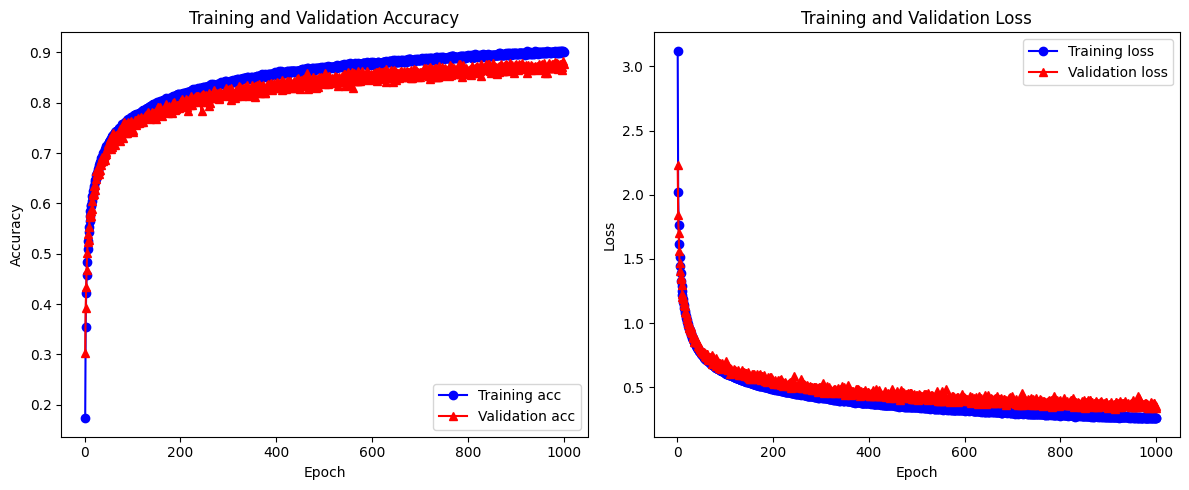

In [19]:
# Assuming you have already prepared your dataset (X_normalized, y_encoded)

# Create the MLP model
mlp_model = create_mlp_model(input_shape, num_classes)

# Train the MLP model
history_mlp = mlp_model.fit(X_normalized, y_encoded, epochs=1000, validation_split=0.2)

# Plot training history for MLP model
print("MLP Model:")
plot_training_history(history_mlp)


In [20]:
mlp_model.save("triad_mlp.h5")

/project/ece601/Automatic Music Transcription/.venv/lib64/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/1000
1080/1080 [==============================] - 2s 1ms/step - loss: 3.6214 - accuracy: 0.0847 - val_loss: 2.7703 - val_accuracy: 0.2117
Epoch 2/1000
1080/1080 [==============================] - 1s 1ms/step - loss: 2.6976 - accuracy: 0.1942 - val_loss: 2.2752 - val_accuracy: 0.3279
Epoch 3/1000
1080/1080 [==============================] - 1s 1ms/step - loss: 2.4079 - accuracy: 0.2481 - val_loss: 2.0820 - val_accuracy: 0.3478
Epoch 4/1000
1080/1080 [==============================] - 1s 1ms/step - loss: 2.2628 - accuracy: 0.2833 - val_loss: 1.9388 - val_accuracy: 0.3962
Epoch 5/1000
1080/1080 [==============================] - 1s 1ms/step - loss: 2.1558 - accuracy: 0.3047 - val_loss: 1.8523 - val_accuracy: 0.4228
Epoch 6/1000
1080/1080 [==============================] - 1s 1ms/step - loss: 2.0699 - accuracy: 0.3272 - val_loss: 1.7569 - val_accuracy: 0.4542
Epoch 7/1000
1080/1080 [==============================] - 1s 1ms/step - loss: 2.0047 - accuracy: 0.3436 - val_loss: 1.7187 -

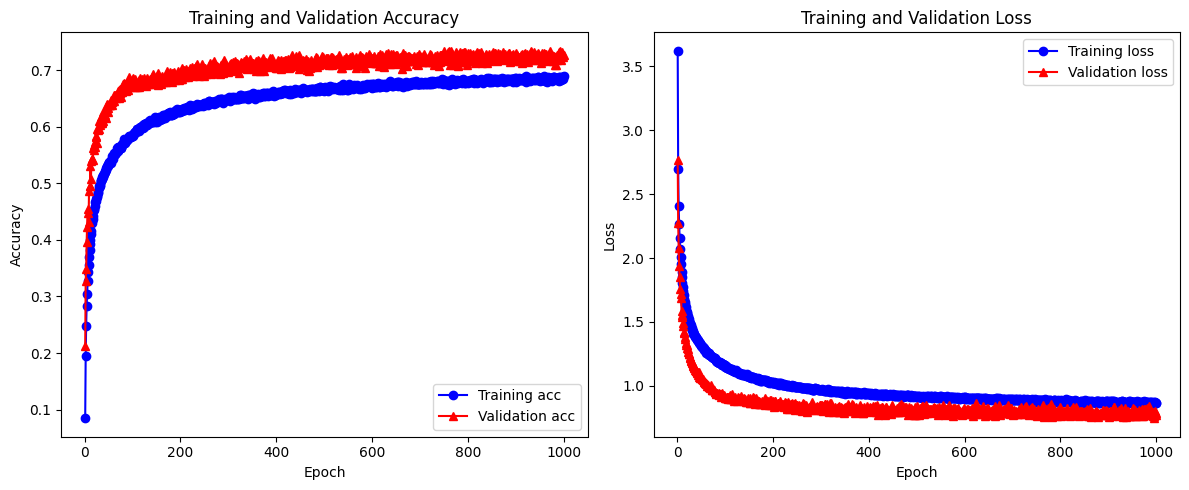

In [23]:
def create_complex_mlp_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100, activation='relu'),  # Adjusted number of neurons
        tf.keras.layers.Dropout(0.3),  # Regularization
        tf.keras.layers.Dense(50, activation='relu'),   # Additional layer
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the more complex MLP model
complex_mlp_model = create_complex_mlp_model(input_shape, num_classes)

# Train the more complex MLP model
history_complex_mlp = complex_mlp_model.fit(X_normalized, y_encoded, epochs=1000, validation_split=0.2)

# Plot training history for the more complex MLP model
print("More Complex MLP Model:")
plot_training_history(history_complex_mlp)
